## Amazon Music Rating Prediction - Kaggle competition

<br>Yingying Zhou    University of Toronto    Faculty of Information </br>
<br>yingying.zhou@mail.utoronto.ca</br>

### build a recommender system model to make predictions related to Amazon Music Reviews

Given a (user, item) pair and associated review data, we want to predict the review’s star rating as accurately as possible. The performance will be measured with MSE

In [1]:
# deploy GPU on google colab:

import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

import torch
print(torch.__version__)
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

2.4.1
Found GPU at: /device:GPU:0
1.8.1+cu101
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [2]:
# import libraries
import numpy as np
import pandas as pd
from sklearn import metrics
!pip install transformers
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizerFast, BertModel, BertConfig

     |████████████████████████████████| 2.0MB 14.6MB/s 
     |████████████████████████████████| 890kB 72.3MB/s 
     |████████████████████████████████| 3.2MB 66.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=78a02d054a26a24894b26cfb63243ecd29d3fb317860710c7cfd7fcc98b96f8b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
# Load dataset in a pandas dataframe
music_df = pd.read_csv("train.csv")
music_df.head()

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,5.0,"08 26, 2014",u92990698,A contemporary jazz and soul performer who's m...,""" CLASSIQUE """,1409011200,Jazz,$8.40,p23649501,3856620,NaN
1,5.0,"05 11, 2003",u36200649,Very good idea to put both the 'pop' and 'orch...,Exceeded my Expectations - This album RAWKS!,1052611200,Alternative Rock,$10.98,p58458313,56086781,NaN
2,5.0,"12 5, 2017",u10721702,This is a great collection of Carole King's so...,A Must-have for Carole King Fans,1512432000,Pop,$5.99,p97027626,55852154,NaN
3,5.0,"09 24, 2013",u86003775,The is album is a brilliant piece of Jazz fusi...,A Master piece!,1379980800,Jazz,$14.64,p43167086,43228100,NaN
4,5.0,"01 14, 2015",u25672859,Waited a LONG time for this DVD to be released...,especially if you like concert videos,1421193600,Alternative Rock,$9.92,p94494236,54425467,NaN


### Data Preprocessing

In [6]:
# Remove the row if summary text is missing
music_df = music_df[music_df['summary'].notna()]
music_df.shape

(149971, 11)

In [7]:
# Extract textual input feature 'summary' and the target variable 'overall' and convert to required format
summary = music_df['summary'].values
labels = music_df['overall'].values
summary = summary.tolist()
summary = [summ.lower() for summ in summary]   # make summary lowercase
labels = labels.tolist()
labels = [label-1 for label in labels]   # convert labels to range 0-4

In [8]:
set(labels)

{0.0, 1.0, 2.0, 3.0, 4.0}

In [9]:
# Training-validation split
from sklearn.model_selection import train_test_split
train_summ, val_summ, train_labels, val_labels = train_test_split(summary, labels, test_size=.2)

### Feature Encoding
source code modified from Huggingface documentation: <br>https://huggingface.co/transformers/custom_datasets.html#sequence-classification-with-imdb-reviews</br>

In [10]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [11]:
train_encodings = tokenizer(train_summ, truncation=True, padding=True)
val_encodings = tokenizer(val_summ, truncation=True, padding=True)

In [12]:
# Turn labels and encodings into a Dataset object in Pytorch:
import torch

class AmazonDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = [float(label) for label in labels]

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AmazonDataset(train_encodings, train_labels)
val_dataset = AmazonDataset(val_encodings, val_labels)


### Fine-tuning & Training
source code modified from Huggingface documentation: <br>https://huggingface.co/transformers/custom_datasets.html#sequence-classification-with-imdb-reviews</br>

In [13]:
# Fine Tuning with Trainer:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=2000,
    save_steps=2000,
)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 1, # multi-class rating regression prediction                  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

trainer = Trainer(
    model=model,                         # the instantiated Huggingface Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
)
trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss
2000,1.030300
4000,0.547400
6000,0.417900


TrainOutput(global_step=7500, training_loss=0.6144577229817708, metrics={'train_runtime': 2118.1129, 'train_samples_per_second': 3.541, 'total_flos': 1.2137048142712416e+16, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 334149, 'init_mem_gpu_alloc_delta': 439069184, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 980086, 'train_mem_gpu_alloc_delta': 1332421120, 'train_mem_cpu_peaked_delta': 99439401, 'train_mem_gpu_peaked_delta': 1916313600})

After 2 epoches of training, the training loss converges.

In [14]:
from sklearn.metrics import mean_squared_error

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    mse = mean_squared_error(labels, preds)
    return {'mse': mse}

### Evaluation

In [15]:
# EVALUATION
trainer = Trainer(
    model=model,                         # the instantiated Huggingface Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)


trainer.evaluate()

{'eval_loss': 0.5076971650123596,
 'eval_mem_cpu_alloc_delta': 429670,
 'eval_mem_cpu_peaked_delta': 1056905,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 123737600,
 'eval_mse': 12.617702950491749,
 'eval_runtime': 53.6172,
 'eval_samples_per_second': 559.429,
 'init_mem_cpu_alloc_delta': 52786,
 'init_mem_cpu_peaked_delta': 18306,
 'init_mem_gpu_alloc_delta': 0,
 'init_mem_gpu_peaked_delta': 0}

In [16]:
trainer = Trainer(
    model=model,                         # the instantiated Huggingface Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)
val_pred = trainer.predict(val_dataset)[0]
val_pred

array([[4.1039796],
       [3.7151034],
       [4.020349 ],
       ...,
       [2.8676999],
       [4.0311675],
       [3.9071004]], dtype=float32)

In [24]:
val_df = pd.DataFrame(data=val_labels, columns=['val_label'])
val_df.reset_index(inplace=True, drop=True)
val_df['val_pred'] = pd.DataFrame(data=val_pred)
val_df['val_pred_int'] = val_df['val_label'].astype(int)
print(val_df.head())
val_df.to_csv('val_data.csv', index=False)

   val_label  val_pred  val_pred_int
0        4.0  4.103980             4
1        4.0  3.715103             4
2        4.0  4.020349             4
3        3.0  3.019607             3
4        2.0  2.453848             2


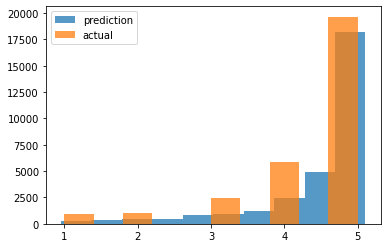

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
# plot the predicted value against actual label for validation set
val_df = pd.read_csv('val_data.csv')
val_df['val_label'] = val_df['val_label']+1
val_df['val_pred'] = val_df['val_pred']+1
val_df['val_pred_int'] = val_df['val_label'].astype(int)

plt.hist(x=val_df['val_pred'], alpha=0.75)
plt.hist(x=val_df['val_label'], alpha=0.75)
plt.legend(['prediction','actual'])
plt.show()

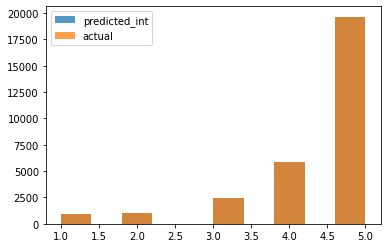

In [4]:
plt.hist(x=val_df['val_pred_int'], alpha=0.75)
plt.hist(x=val_df['val_label'], alpha=0.75)

plt.legend(['predicted_int','actual'])
plt.show()

### Test set preprocessing

In [49]:
test_df = pd.read_csv('/test.csv')   # load the test set
test_df.head()

,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,"02 11, 2017",u04140621,ok,Five Stars,1486771200,Pop,$31.20,p65721979,98944233,NaN
1,"01 29, 2018",u74766187,The 1955 and 1958 sets alone are worth the pur...,Buy It For the 1955 Set With Monk!,1517184000,Jazz,$34.04,p87809670,33903910,NaN
2,"08 29, 2005",u31689638,Mary J Blige is someone most people know of. S...,Mary's excellent debut! Classic!,1125273600,Pop,$1.72,p52702240,35386470,NaN
3,"11 2, 2015",u35613516,Very good satch album,Four Stars,1446422400,Pop,$10.99,p01314374,12404766,NaN
4,"01 3, 2012",u93320378,Well there are hundreds of Christmas anthologi...,CD lives up to its name,1325548800,Alternative Rock,$7.98,p84396269,68253688,NaN


In [50]:
test_df[test_df['summary'].isna()]    # check if there are any missing summary

,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
7888,"02 23, 2018",u52398997,NaN,NaN,1519344000,Pop,$7.32,p64058590,64457564,NaN
9526,"06 22, 2004",u25000049,This is by far more personal than YHF. Slight...,NaN,1087862400,Alternative Rock,$11.97,p42229219,91234847,NaN
13015,"03 1, 2015",u60876074,NaN,NaN,1425168000,Pop,$11.99,p27493690,81791504,NaN
16970,"03 8, 2017",u24609876,Awesome,NaN,1488931200,Pop,$16.99,p58289362,48432559,NaN


In [51]:
# Replace missing summary with its corresponding reviewText
test_df['summary'] = np.where(test_df['summary'].isna(), test_df['reviewText'], test_df['summary']) 
test_df['summary'].isna().sum()

2

In [52]:
# replace NaN in summary with empty string
test_df['summary'] = test_df['summary'].fillna('')

In [53]:
# Extract textual input feature 'summary' and convert to lowercase
test_summ = test_df['summary'].values
test_summ = test_summ.tolist()
test_summ = [summ.lower() for summ in test_summ]

In [55]:
max_len = 0

for summ in test_summ:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(summ, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max summary length: ', max_len)

Max summary length:  116


In [56]:
# Tokenize textual summary for test set
test_encodings = tokenizer(test_summ, truncation=True, padding=True)

In [58]:
test_index = test_df.index.values

In [59]:
# Turn test set encodings into a Dataset object in Pytorch:
import torch

class AmazonDataset_test(torch.utils.data.Dataset):
    def __init__(self, encodings, index):
        self.encodings = encodings
        self.index = index
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
      return len(self.index)
test_dataset = AmazonDataset_test(test_encodings, test_index)


In [60]:
len(test_dataset)

20000

### Predict the rating labels for test set

In [61]:
# PREDICTION
trainer = Trainer(
    model=model,                         # the instantiated Huggingface Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
)


predictions = trainer.predict(test_dataset)[0]
predictions

array([[4.1240745],
       [3.8872337],
       [4.015919 ],
       ...,
       [3.9370584],
       [4.0231037],
       [3.6393206]], dtype=float32)

In [62]:
predictions.shape


(20000, 1)

In [64]:
test_df['prediction'] = predictions
test_df.head()

,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image,prediction
0,"02 11, 2017",u04140621,ok,Five Stars,1486771200,Pop,$31.20,p65721979,98944233,NaN,4.124074
1,"01 29, 2018",u74766187,The 1955 and 1958 sets alone are worth the pur...,Buy It For the 1955 Set With Monk!,1517184000,Jazz,$34.04,p87809670,33903910,NaN,3.887234
2,"08 29, 2005",u31689638,Mary J Blige is someone most people know of. S...,Mary's excellent debut! Classic!,1125273600,Pop,$1.72,p52702240,35386470,NaN,4.015919
3,"11 2, 2015",u35613516,Very good satch album,Four Stars,1446422400,Pop,$10.99,p01314374,12404766,NaN,3.087710
4,"01 3, 2012",u93320378,Well there are hundreds of Christmas anthologi...,CD lives up to its name,1325548800,Alternative Rock,$7.98,p84396269,68253688,NaN,3.870686


In [ ]:
test_df['7888']

In [65]:
predictions[1][0]

3.8872337

In [66]:
prediction = [pred for pred_list in predictions for pred in pred_list]
prediction

[4.1240745,
 3.8872337,
 4.015919,
 3.0877101,
 3.8706863,
 3.9227552,
 3.8359382,
 3.4686313,
 3.6822338,
 3.841103,
 4.1240745,
 3.8444548,
 3.7359347,
 2.9385936,
 3.3710132,
 3.6144552,
 3.097591,
 1.5009,
 3.4412367,
 3.913838,
 4.027939,
 3.9241257,
 4.048945,
 3.8699174,
 3.7235622,
 2.3569741,
 3.7265668,
 3.4264963,
 4.0160694,
 3.9838128,
 3.7083101,
 3.42086,
 4.047756,
 3.4993064,
 3.9709196,
 4.1240745,
 3.9228733,
 3.5439973,
 3.9947543,
 3.7751555,
 3.9693189,
 3.8640842,
 3.8313382,
 4.081412,
 4.0392203,
 3.69243,
 3.9355884,
 1.8148257,
 4.005468,
 4.0122614,
 4.028629,
 3.9873424,
 3.4517665,
 4.1240745,
 3.6643672,
 4.002091,
 3.61878,
 3.91685,
 3.566455,
 3.6639268,
 4.0526123,
 3.630549,
 4.067557,
 3.6336176,
 4.0142274,
 0.49525568,
 4.1240745,
 3.2562943,
 0.1667604,
 3.7672837,
 4.0419464,
 4.1240745,
 3.4286978,
 2.9759285,
 3.9852767,
 4.1240745,
 4.1240745,
 4.012345,
 2.4785998,
 4.1240745,
 0.50412995,
 3.6587338,
 3.7172093,
 4.0484047,
 3.5957403,
 3.9

In [67]:
type(prediction[0])

numpy.float32

In [74]:
# Write the preditions result to a new csv file 'rating_predictions'

predictions = open('/rating_predictions.csv', 'w')
i=0
for l in open('/rating_pairs.csv'):
    if l.startswith('userID'):
        #header
        predictions.write(l)
        continue
    u,p = l.strip().split('-')
    predictions.write(u + '-' + p + str(prediction[i]+1) + '\n')
    i+=1
predictions.close()

In [20]:
rating_predictions = pd.read_csv('rating_predictions.csv')
rating_predictions.head()

,userID-itemID,prediction
0,u04140621-p65721979,5.124074
1,u74766187-p87809670,4.887234
2,u31689638-p52702240,5.015919
3,u35613516-p01314374,4.087710
4,u93320378-p84396269,4.870686


In [21]:
# check the value range of prediction, we find the maximum of larger than 5. Actual label range: [1-5]
# convert predictions larger than 5 to 5
rating_predictions['prediction'] = rating_predictions['prediction'].apply(lambda x: int(x) if x > 5 else x)
rating_predictions.head()

,userID-itemID,prediction
0,u04140621-p65721979,5.000000
1,u74766187-p87809670,4.887234
2,u31689638-p52702240,5.000000
3,u35613516-p01314374,4.087710
4,u93320378-p84396269,4.870686


In [22]:
rating_predictions.to_csv('rating_predictions_2.csv', index=False)